In [1]:
from keras.layers import Dense, Input, Lambda
from keras.layers import Flatten, Reshape, Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse
from keras import backend as K

import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse
import os

Using TensorFlow backend.



  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [2]:
# Reshape data 
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255., X_test / 255.
X_train, X_test = X_train.reshape([-1, 28, 28, 1]), X_test.reshape([-1, 28, 28, 1])
X_train = X_train.astype(np.float32, copy=False)
X_test = X_test.astype(np.float32, copy=False)


In [3]:
X_dim = 784 # input dimension
batch_size = 64 # mini-batch size
epochs = 30 # number of epochs
hidden_dim = 256 # hidden layer dimension
z_dim = 2 # latent dimension
input_shape = (28, 28, 1) # input size
filters = 32 # number of filters

In [4]:
# plot latent space in 2D
def plot_digits(X, y, encoder, batch_size=128):
    z_mu, _, _ = encoder.predict(X, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    return fig
    

# Generate mnist manifold
def generate_manifold(decoder):  
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]   
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit           
    fig = plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)  
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()  
    return fig
      
# Plot images
def reconstruction(X_test):
    w = h = int(np.sqrt(X_dim))
    X_hat = vae.predict(X_test)
    n = np.sqrt(100).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (X_hat[i*n+j, :].reshape(h, w), 
                 X_test[i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    fig = plt.figure(figsize=(20, 40))
    plt.imshow(I_reconstructed, cmap='gray')
    return fig

# Calculate FID Score
def fid_score(X_test, X_hat):
    m = X_test.shape[0]
    X = X_test.reshape((m, X_dim))
    Y = X_hat.reshape((m, X_dim))
    mu1, sigma1 = X.mean(axis=0), cov(X, rowvar=False)
    mu2, sigma2 = Y.mean(axis=0), cov(Y, rowvar=False)
    sum_square_diff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(covmean):
        covmean = covmean.real
    fid = sum_square_diff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

if not os.path.exists('results/'):
    os.makedirs('results/')

    

In [5]:
# Reparameterization trick
def sampling(args):
    z_mu, z_log_var = args
    eps = tf.random_normal(K.shape(z_log_var), dtype=np.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mu + K.exp(z_log_var / 2) * eps
    return z

In [6]:
# Encoder network
inputs = Input(shape=input_shape, name='input')
x = Conv2D(filters, (3, 3), activation='relu', strides=2, padding='same')(inputs)
x = Conv2D(filters*2, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Dropout(0.25)(x)

# Save the shape information for later decoder network
shape = x.get_shape().as_list()

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
z_mu = Dense(z_dim, name='z_mu')(x)
z_log_var = Dense(z_dim, name='z_log_var')(x)
z = Lambda(sampling, name='z')([z_mu, z_log_var])
# Instantiate encoder model
encoder = Model(inputs, [z_mu, z_log_var, z], name='vae_encoder')
encoder.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vae_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 7, 7, 64)     0           conv2d_2[0][0]                   
_______

In [7]:
# Decoder network
z_inputs = Input(shape=(z_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(z_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(filters*2, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(filters, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Dropout(0.25)(x)
outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)
# Instantiate decoder model
decoder = Model(z_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289 

In [8]:
# Convolutional VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='conv_vae')

In [9]:
# Loss function
# Reconstruction loss
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss = reconstruction_loss * X_dim
# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mu) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)

vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "conv_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
vae_encoder (Model)          [(None, 2), (None, 2), (N 119332    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         65089     
Total params: 184,421
Trainable params: 184,421
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [10]:
# Training session
history = vae.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 17s 287us/step - loss: 50.3373 - val_loss: 43.3065
Epoch 2/30
60000/60000 [==============================] - 14s 235us/step - loss: 41.7661 - val_loss: 40.4739
Epoch 3/30
60000/60000 [==============================] - 14s 235us/step - loss: 40.2937 - val_loss: 39.4731
Epoch 4/30
60000/60000 [==============================] - 14s 234us/step - loss: 39.5474 - val_loss: 39.0330
Epoch 5/30
60000/60000 [==============================] - 14s 231us/step - loss: 39.0716 - val_loss: 38.4416
Epoch 6/30
60000/60000 [==============================] - 14s 228us/step - loss: 38.7116 - val_loss: 38.2213
Epoch 7/30
60000/60000 [==============================] - 14s 232us/step - loss: 38.4154 - val_loss: 37.8489
Epoch 8/30
60000/60000 [==============================] - 14s 231us/step - loss: 38.1689 - val_loss: 37.8553
Epoch 9/30
60000/60000 [==============================] - 14s 227us/step - lo

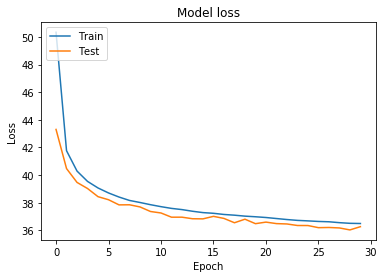

In [11]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

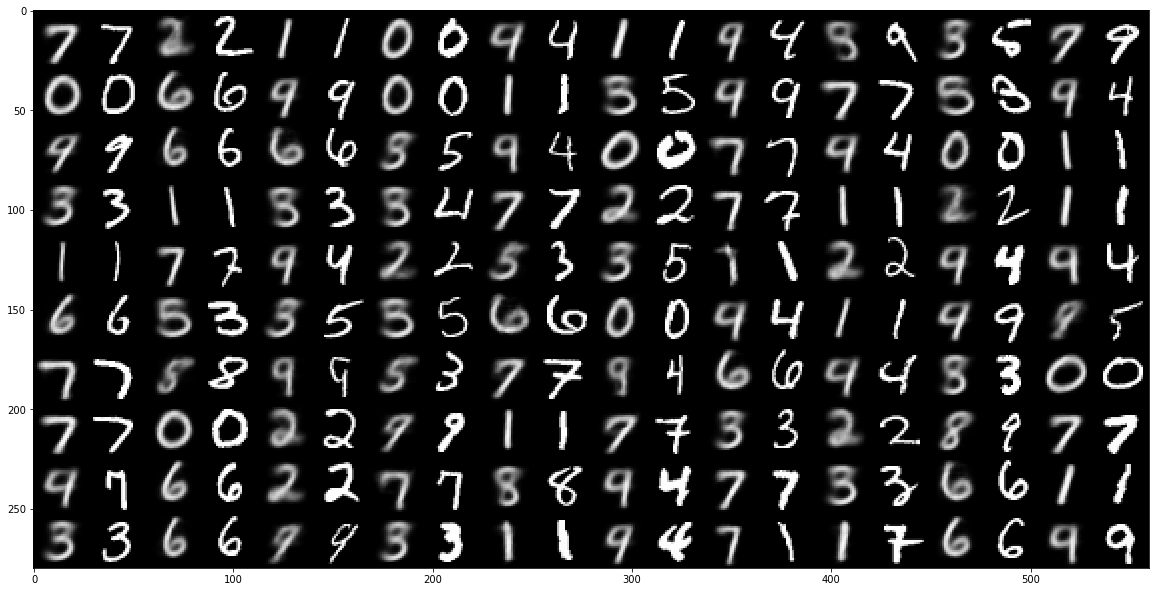

In [12]:
# Reconstruction of images
fig = reconstruction(X_test[:100])
fig.savefig('results/reconstruction_images.png')

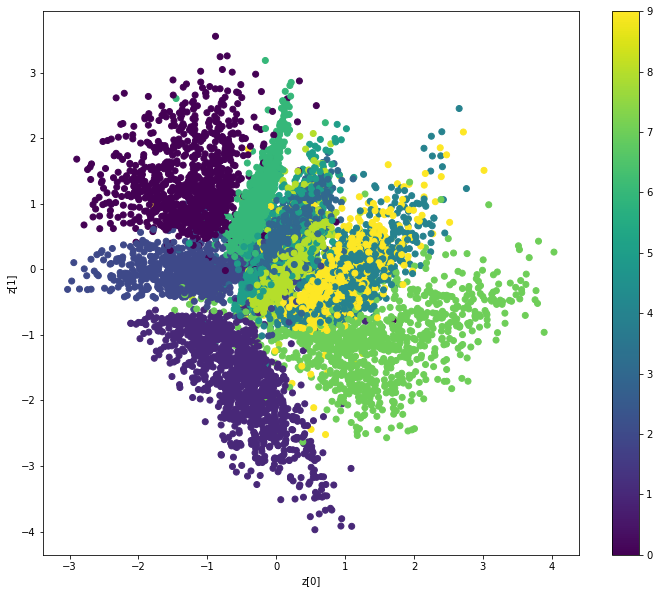

In [13]:
# Plot latent space in 2D    
fig = plot_digits(X_test, y_test, encoder)
fig.savefig('results/latent_space_representation.png')

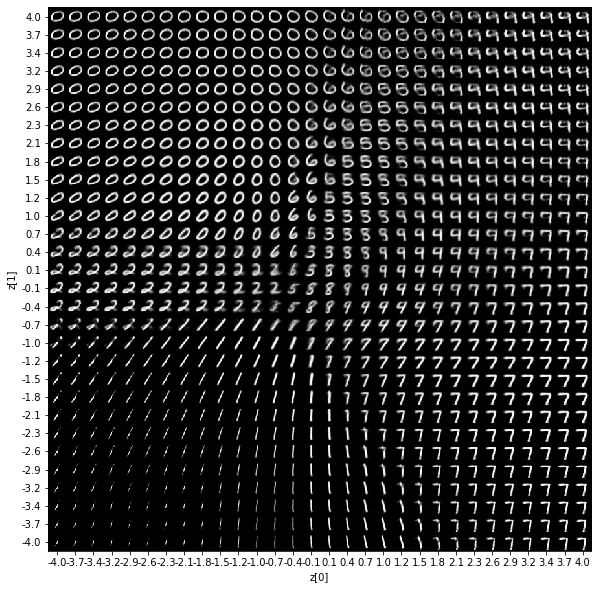

In [14]:
# Generate MNIST manifold
fig = generate_manifold(decoder)
fig.savefig('results/mnist_manifold.png')

In [15]:
# Evaluate images quality in terms of FID score
X_hat = vae.predict(X_test)
fid = fid_score(X_test, X_hat)
print('FID Score = ', fid)

FID Score =  16.812694071827046
